In [1]:
import os
import json
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Dataset location
SOURCE_PATH = 'drive/MyDrive/music/'

# Path to labels and processed data file, json format.
JSON_PATH = 'drive/MyDrive/data.json'

# Sampling rate.
sr = 22050

# Let's make sure all files have the same amount of samples, pick a duration right under 30 seconds.
TOTAL_SAMPLES = 10 * sr

# X amount of slices => X times more training examples.
NUM_SLICES = 10
SAMPLES_PER_SLICE = int(TOTAL_SAMPLES / NUM_SLICES)

In [ ]:
def preprocess_data(source_path, json_path):

    # Let's create a dictionary of labels and processed data.
    mydict = {
        "labels": [],
        "mfcc": []
        }

    # Let's browse each file, slice it and generate the 13 band mfcc for each slice.
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(source_path)):

        for file in filenames:
            song, sr = librosa.load(os.path.join(dirpath, file), duration=29)

            for s in range(NUM_SLICES):
                start_sample = SAMPLES_PER_SLICE * s
                end_sample = start_sample + SAMPLES_PER_SLICE
                mfcc = librosa.feature.mfcc(y=song[start_sample:end_sample], sr=sr, n_mfcc=13)
                mfcc = mfcc.T
                mydict["labels"].append(i-1)
                mydict["mfcc"].append(mfcc.tolist())

    # Let's write the dictionary in a json file.    
    with open(json_path, 'w') as f:
        json.dump(mydict, f)
    f.close()

In [4]:
def load_data(json_path):

    with open(json_path, 'r') as f:
        data = json.load(f)
    f.close()

    # Let's load our data into numpy arrays for TensorFlow compatibility.
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    print(X.shape)

    return X, y

In [5]:
def prepare_datasets(inputs, targets, split_size):
    
    # Creating a validation set and a test set.
    inputs_train, inputs_val, targets_train, targets_val = train_test_split(inputs, targets, test_size=split_size)
    inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs_train, targets_train, test_size=split_size)
    
    # Our CNN model expects 3D input shape.
    inputs_train = inputs_train[..., np.newaxis]
    inputs_val = inputs_val[..., np.newaxis]
    inputs_test = inputs_test[..., np.newaxis]
    
    return inputs_train, inputs_val, inputs_test, targets_train, targets_val, targets_test

In [6]:
def design_model(input_shape):
    with tf.device('/device:GPU:0'):
    # Let's design the model architecture.
      model = tf.keras.models.Sequential([
          
          tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
          tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
          tf.keras.layers.BatchNormalization(),
          
          tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
          tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
          tf.keras.layers.BatchNormalization(),
          
          tf.keras.layers.Conv2D(32, (2,2), activation='relu'),
          tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(0.3),
          
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(64, activation='relu'), 
          tf.keras.layers.Dense(len(np.unique(targets)), activation='softmax')
      ])

    return model

In [7]:
def make_prediction(model, X, y, idx):
    
    genre_dict = {
        0 : "Blues",
        1 : "Classical",
        2 : "EDM",
        3 : "Ghazal",
        4 : "Hip-Hop",
        5 : "Metal",
        6 : "Pop",
        7 : "Qawwali",
        8 : "Rap",
        9 : "Rock",
        }
        
    predictions = model.predict(X)
    genre = np.argmax(predictions[idx])
    
    print("\n---Now testing the model for one audio file---\nThe model predicts: {}, and ground truth is: {}.\n".format(genre_dict[genre], genre_dict[y[idx]]))

In [8]:
def plot_performance(hist):
    
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [ ]:
preprocess_data(source_path=SOURCE_PATH, json_path=JSON_PATH)

(38140, 44, 13)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 42, 11, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21, 6, 32)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 21, 6, 32)        128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 4, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 2, 32)        0         
 2D)                                                             
                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30


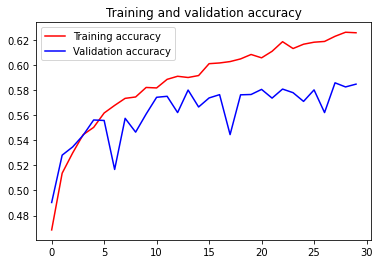

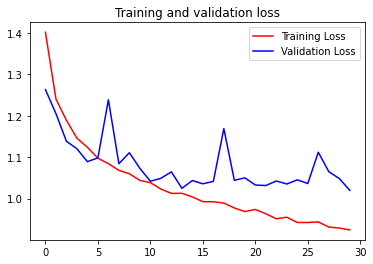

In [9]:
inputs, targets = load_data(json_path=JSON_PATH)
        
Xtrain, Xval, Xtest, ytrain, yval, ytest = prepare_datasets(inputs, targets, 0.2)

input_shape = (Xtrain.shape[1], Xtrain.shape[2], 1)
model = design_model(input_shape)

model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.001),
              loss='sparse_categorical_crossentropy',
              metrics = ['acc']
                    )
    
model.summary()   

# Training the model.
history = model.fit(Xtrain, ytrain,
                    validation_data=(Xval, yval),
                    epochs=30,
                    batch_size=32,
                    verbose = 5 
                    )

plot_performance(history)

In [ ]:
make_prediction(model, Xtest, ytest, 24)


---Now testing the model for one audio file---
The model predicts: Hip-Hop, and ground truth is: Blues.



In [11]:
test_loss, test_acc = model.evaluate(Xtest,  ytest, verbose=2)
print('Test accuracy:', test_acc)

191/191 - 1s - loss: 1.0180 - acc: 0.5832 - 814ms/epoch - 4ms/step
Test accuracy: 0.5831558108329773
